# Data Analysis for Lab3 Dataset

## Introduction
In this section, we analyze the yield data for the month of March.
We visualize the actual and predicted values to observe any discrepancies.

## Plotting Yield Data

In [1]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np


## Basic values

Test

c = 6.0
T  = 34.243513

c = 5.0	
T = 25.068095

c = 4.0	
T = 29.621757

c = 3.0	
T = 27.310878

c = 3.0
T = 30.0

c = 3.5	
T = 35

c = 3.7
T = 38

c = 3.75
T  = 40.0

c = 3.70
T  = 39.0

In [2]:
# Define a dictionary to map input variable names to their descriptive labels
inputs_labels = {
    'c': 'concentration',
    'T': 'Temperature'
}

# Define the initial values for concentration, temperature, and reaction rate
c = 2.0  # mM (concentration)
T = 25.0  # °C (temperature)
rate = 5.77  # mole/s (reaction rate)

## Value intervals

In [3]:
# Create a list of tuples with each variable's low, center, and high values
dat = [
    ('c', 0.80 * c, c, 1.20 * c),  # Concentration: low is 80% of c, center is c, high is 120% of c
    ('T', 0.80 * T, T, 1.20 * T)    # Temperature: low is 80% of T, center is T, high is 120% of T
]

# Create a Pandas DataFrame from the data list, specifying the column names
inputs_df = pd.DataFrame(dat, columns=['index', 'low', 'center', 'high'])

# Set the 'index' column as the DataFrame index for easier access
inputs_df = inputs_df.set_index('index')

# Map the variable labels to the DataFrame index, providing a default empty string for unmapped values
inputs_df['label'] = inputs_df.index.map(lambda z: inputs_labels.get(z, ''))

# Print the resulting DataFrame to display its contents
print(inputs_df)

from computing import computing

real_experiment, results = computing(inputs_df)

c_array  = real_experiment['concentration']
T_array = real_experiment['Temperature']

        low  center  high          label
index                                   
c       1.6     2.0   2.4  concentration
T      20.0    25.0  30.0    Temperature


**FIRST EXPERIMENT**

In [4]:
y=[4.093000401645197,4.77827155867177,6.403139782334854,8.199982171532273,5.847007863003852,5.695005284140945,5.584338442337459,5.806999272226782,5.814771183739139]

results['y']= y
results

,c,T,y
0,-1,-1,4.093000
1,1,-1,4.778272
2,-1,1,6.403140
3,1,1,8.199982
4,0,0,5.847008
5,0,0,5.695005
6,0,0,5.584338
7,0,0,5.806999
8,0,0,5.814771


In [5]:
# Data , 4 corners and 5 center points:

df = pd.DataFrame(results,columns=['c','T','y'])
#inputs_df = inputs_df.set_index(['index'])

#print dataframe
df

,c,T,y
0,-1,-1,4.093000
1,1,-1,4.778272
2,-1,1,6.403140
3,1,1,8.199982
4,0,0,5.847008
5,0,0,5.695005
6,0,0,5.584338
7,0,0,5.806999
8,0,0,5.814771


In [6]:
y1 = results['y']
xlabs=['c','T']
x = results[xlabs]

res1 = smf.ols(formula='y ~ c + T + c:T', data=results).fit()

res1.summary()

/home/oscar/miniconda3/envs/dhenv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     212.9
Date:                Tue, 08 Oct 2024   Prob (F-statistic):           1.08e-05
Time:                        10:27:43   Log-Likelihood:                 8.5521
No. Observations:                   9   AIC:                            -9.104
Df Residuals:                       5   BIC:                            -8.315
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8025      0.042    138.682      0.000       5.695       5.910
c              0.6205      0.063      9.887      0.000       0.459       0.782
T              1.4330      0.063     22.832      0.000       1.272       1.594
c:T            0.2779      0.063      4.428      0.007       0.117       0.439
==============================================================================
Omnibus:                        7.690   Durbin-Watson:                   1.085
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                3.108
Skew:                          -1.408   Prob(JB):                        0.211
Kurtosis:                       3.595   Cond. No.                         1.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
#est1 = sm.OLS(y1,x).fit()
res1 = smf.ols(formula='y ~ c + T', data=results).fit()
print(res1.summary())
res1

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     75.48
Date:                Tue, 08 Oct 2024   Prob (F-statistic):           5.59e-05
Time:                        10:27:43   Log-Likelihood:                 1.3812
No. Observations:                   9   AIC:                             3.238
Df Residuals:                       6   BIC:                             3.829
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8025      0.085     68.482      0.0

/home/oscar/miniconda3/envs/dhenv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)


ybar = 5.8025 + 0.6205\*c + 1.4330\*T

$\Delta$ = 1.4339/0.6205

In [8]:
Origin = [c,T]
delta= [1.0, 1.4339/0.6205]

march=[]
for i in range(0,len(y)):
    march.append((Origin[0]+(i+1)*delta[0],Origin[1]+(i+1)*delta[1]))

March=pd.DataFrame(march,columns=['c', 'T'])
ypred=res1.predict(March)

March['ypred']=ypred

March

,c,T,ypred
0,3.0,27.310878,46.799551
1,4.0,29.621757,50.731482
2,5.0,31.932635,54.663412
3,6.0,34.243513,58.595342
4,7.0,36.554392,62.527273
5,8.0,38.865270,66.459203
6,9.0,41.176148,70.391134
7,10.0,43.487027,74.323064
8,11.0,45.797905,78.254994


In [9]:
c = 6.0
T  = 34.243513
# Create a list of tuples with each variable's low, center, and high values
dat = [
    ('c', 0.8 * c, c, 1.20 * c),  # Concentration: low is 80% of c, center is c, high is 120% of c
    ('T', 0.8 * T, T, 1.20 * T)    # Temperature: low is 80% of T, center is T, high is 120% of T
]

# Create a Pandas DataFrame from the data list, specifying the column names
inputs_df = pd.DataFrame(dat, columns=['index', 'low', 'center', 'high'])

# Set the 'index' column as the DataFrame index for easier access
inputs_df = inputs_df.set_index('index')

# Map the variable labels to the DataFrame index, providing a default empty string for unmapped values
inputs_df['label'] = inputs_df.index.map(lambda z: inputs_labels.get(z, ''))

# Print the resulting DataFrame to display its contents
print(inputs_df)

from computing import computing

real_experiment, results = computing(inputs_df)

c_array  = real_experiment['concentration'].tolist()
T_array = real_experiment['Temperature'].tolist()

print(f'c = {c_array}')
print(f'T = {T_array}')


            low     center       high          label
index                                               
c       4.80000   6.000000   7.200000  concentration
T      27.39481  34.243513  41.092216    Temperature
c = [4.800000000000001, 7.199999999999999, 4.800000000000001, 7.199999999999999, 6.0, 6.0, 6.0, 6.0, 6.0]
T = [27.3948104, 27.3948104, 41.092215599999996, 41.092215599999996, 34.243513, 34.243513, 34.243513, 34.243513, 34.243513]


In [11]:
y = [7.418120954509438,
1.3561542905270603,
11.445462201747263,
2.0714185981812903,
5.484404673522267,
5.623460723801533,
5.453073122010716,
5.366474093954773,
5.368822288765668]
results['y']= y

y1 = results['y']
xlabs=['c','T']
x = results[xlabs]

res1 = smf.ols(formula='y ~ c + T + c:T', data=results).fit()

res1.summary()

res1 = smf.ols(formula='y ~ c + T', data=results).fit()
print(res1.summary())
res1

/home/oscar/miniconda3/envs/dhenv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)
/home/oscar/miniconda3/envs/dhenv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     69.46
Date:                Tue, 08 Oct 2024   Prob (F-statistic):           7.10e-05
Time:                        10:27:43   Log-Likelihood:                -7.5411
No. Observations:                   9   AIC:                             21.08
Df Residuals:                       6   BIC:                             21.67
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.5097      0.228     24.129      0.0

In [31]:
c = 6.0
T  = 34.243513
Origin = [c,T]
delta= [1.0, 1.1857/3.8590]

march=[]
for i in range(0,len(y)):
    march.append((Origin[0]+(i+1)*delta[0],Origin[1]+(i+1)*delta[1]))

March=pd.DataFrame(march,columns=['c', 'T'])
ypred=res1.predict(March)

March['ypred']=ypred

March

# ax=March['ypred'].plot()
# ax.set_xlabel("step")
# ax.set_ylabel("Yield")

,c,T,ypred
0,7.0,34.550769,59.896784
1,8.0,34.858025,58.406955
2,9.0,35.165280,56.917126
3,10.0,35.472536,55.427296
4,11.0,35.779792,53.937467
5,12.0,36.087048,52.447638
6,13.0,36.394303,50.957809
7,14.0,36.701559,49.467979
8,15.0,37.008815,47.978150


In [63]:
c = 3.70
T  = 39.0

# Create a list of tuples with each variable's low, center, and high values
dat = [
    ('c', 0.8 * c, c, 1.20 * c),  # Concentration: low is 80% of c, center is c, high is 120% of c
    ('T', 0.8 * T, T, 1.20 * T)    # Temperature: low is 80% of T, center is T, high is 120% of T
]

# Create a Pandas DataFrame from the data list, specifying the column names
inputs_df = pd.DataFrame(dat, columns=['index', 'low', 'center', 'high'])

# Set the 'index' column as the DataFrame index for easier access
inputs_df = inputs_df.set_index('index')

# Map the variable labels to the DataFrame index, providing a default empty string for unmapped values
inputs_df['label'] = inputs_df.index.map(lambda z: inputs_labels.get(z, ''))

# Print the resulting DataFrame to display its contents
print(inputs_df)

from computing import computing

real_experiment, results = computing(inputs_df)

c_array  = real_experiment['concentration'].tolist()
T_array = real_experiment['Temperature'].tolist()

print(f'c = {c_array}')
print(f'T = {T_array}')

         low  center   high          label
index                                     
c       2.96     3.7   4.44  concentration
T      31.20    39.0  46.80    Temperature
c = [2.9600000000000004, 4.44, 2.9600000000000004, 4.44, 3.7, 3.7, 3.7, 3.7, 3.7]
T = [31.200000000000003, 31.200000000000003, 46.8, 46.8, 39.0, 39.0, 39.0, 39.0, 39.0]


In [64]:
y = [10.198819978308894,
10.524033796374926,
11.039326780371198,
10.87110871563581,
13.91363162951745,
13.92923511074255,
13.748190855517132,
13.802006153111138,
13.806009629601999]

results['y']= y

res1 = smf.ols(formula='y ~ c + T', data=results).fit()
print(res1.summary())
res1

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.312
Method:                 Least Squares   F-statistic:                   0.04767
Date:                Tue, 08 Oct 2024   Prob (F-statistic):              0.954
Time:                        11:38:41   Log-Likelihood:                -16.909
No. Observations:                   9   AIC:                             39.82
Df Residuals:                       6   BIC:                             40.41
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.4258      0.647     19.217      0.0

/home/oscar/miniconda3/envs/dhenv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [65]:
c = 3.70
T  = 39.0
Origin = [c,T]
delta= [1.0, 0.0392/0.2969]

march=[]
for i in range(0,len(y)):
    march.append((Origin[0]+(i+1)*delta[0],Origin[1]+(i+1)*delta[1]))

March=pd.DataFrame(march,columns=['c', 'T'])
ypred=res1.predict(March)

March['ypred']=ypred

March

,c,T,ypred
0,4.7,39.132031,24.228409
1,5.7,39.264062,24.306858
2,6.7,39.396093,24.385306
3,7.7,39.528124,24.463754
4,8.7,39.660155,24.542203
5,9.7,39.792186,24.620651
6,10.7,39.924217,24.699099
7,11.7,40.056248,24.777548
8,12.7,40.188279,24.855996


In [66]:
res2 = smf.ols(formula='y ~ c + T + c:T + I(c**2) + I(T**2)', data=March).fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     14.41
Date:                Tue, 08 Oct 2024   Prob (F-statistic):            0.00511
Time:                        11:39:22   Log-Likelihood:                -9.0668
No. Observations:                   9   AIC:                             24.13
Df Residuals:                       6   BIC:                             24.73
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6.434e-06   5.92e-06     -1.087      0.3

/home/oscar/miniconda3/envs/dhenv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)


**Polynomial regression**

In [72]:
Origin = [3.7,39.0]
delta= [1.0, 0.0392/0.2969]

march=[]
for i in range(0,len(y)):
    march.append((Origin[0]+(i+1)*delta[0],Origin[1]+(i+1)*delta[1]))

March=pd.DataFrame(march,columns=['c', 'T'])
ypred=res2.predict(March)

March['ypred']=ypred

March

,c,T,ypred
0,4.7,39.132031,9.680006
1,5.7,39.264062,10.648081
2,6.7,39.396093,11.495460
3,7.7,39.528124,12.222145
4,8.7,39.660155,12.828135
5,9.7,39.792186,13.313430
6,10.7,39.924217,13.678029
7,11.7,40.056248,13.921934
8,12.7,40.188279,14.045143


Text(0, 0.5, 'Yield')

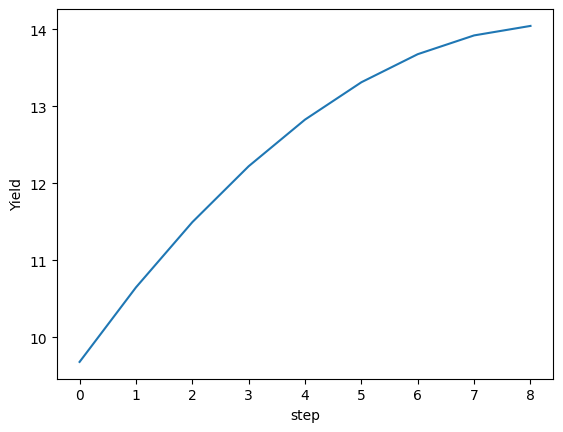

In [73]:
ax=March['ypred'].plot()
ax.set_xlabel("step")
ax.set_ylabel("Yield")

**Latin Hypercube design**

In [82]:
from doepy import read_write, build

c = March['c'].tolist()
T = March['T'].tolist()
ypred = March['ypred'].tolist()
lhs_design = build.lhs({
    
})
#lhs_df = pd.DataFrame(lhs_design, columns['Factor1', 'Factor2', 'Factor3'])

TypeError: 'int' object is not iterable